In [1]:
import json
import os, re
from pprint import pprint
import pandas as pd

In [2]:
files = []
for file in os.listdir('data'):
    if re.match('^2.*jsons', file):
        files.append(file)

In [3]:
def parseJsons(file):
    with open('data/{}'.format(file)) as f:
        sl = []
        for i, line in enumerate(f):
            _s = pd.read_json(line, typ='series')
            sl.append(_s)
        df = pd.concat(sl, axis=1).T
        df['time'] = df['time'].astype(float)
        df['acc'] = df['acc'].astype(float)
        df['loss'] = df['loss'].astype(float)
    return df

In [4]:
for i, file in enumerate(files):
    if i == 0:
        df_all = parseJsons(file)
    else:
        df_all = df_all.append(parseJsons(file))

In [5]:
df_all

,acc,architecture,batch_times,dataset,epoch,instance_type,loss,time
0,0.268619,custom,"[1.3446545600891113, 0.03342413902282715, 0.03...",cifar,1,p2.xlarge,1.997834,5.570574
1,0.335648,custom,"[0.03270435333251953, 0.024114370346069336, 0....",cifar,2,p2.xlarge,1.833734,4.060212
2,0.365439,custom,"[0.023899078369140625, 0.014857292175292969, 0...",cifar,3,p2.xlarge,1.735759,4.046518
3,0.406300,custom,"[0.023813486099243164, 0.023743629455566406, 0...",cifar,4,p2.xlarge,1.629520,4.051415
4,0.428643,custom,"[0.0235443115234375, 0.025518178939819336, 0.0...",cifar,5,p2.xlarge,1.567903,4.030068
5,0.450181,custom,"[0.023618221282958984, 0.024957895278930664, 0...",cifar,6,p2.xlarge,1.518550,4.026983
6,0.465076,custom,"[0.02612161636352539, 0.024294137954711914, 0....",cifar,7,p2.xlarge,1.472598,4.072459
7,0.482589,custom,"[0.024123191833496094, 0.024301767349243164, 0...",cifar,8,p2.xlarge,1.432928,4.064909
8,0.486715,custom,"[0.02433943748474121, 0.02443695068359375, 0.0...",cifar,9,p2.xlarge,1.406139,4.044221
9,0.511977,custom,"[0.02361583709716797, 0.023758411407470703, 0....",cifar,10,p2.xlarge,1.365581,4.047320


In [6]:
df_all.dtypes

acc              float64
architecture      object
batch_times       object
dataset           object
epoch             object
instance_type     object
loss             float64
time             float64
dtype: object

In [7]:
import numpy as np

In [ ]:
df_all.groupby(['dataset', 'architecture','instance_type']).aggregate([np.mean, np.std])

In [8]:
df_all = df_all.reset_index()
df_all['data_arch'] = df_all['dataset'] + '_' + df_all['architecture']

In [9]:
import matplotlib.pyplot as plt

In [44]:
df_all.groupby('data_arch')['time'].min()

data_arch
cifar_custom          4.021991
cifar_kerasdef        4.330202
imdb_kerasdef        10.130305
imdb_lstmkerasdef    39.194983
mnist_custom         12.846638
mnist_kerasdef       10.654837
Name: time, dtype: float64

In [73]:
df_grp = df_all.groupby('data_arch')

In [74]:
fig, axes = plt.subplots(len(df_grp.groups), 1, figsize=[10, 12])

# Loop through each group and plot boxplot to appropriate axis
for i, k in enumerate(df_grp.groups.keys()):
    group = df_grp.get_group(k)
    group.boxplot(ax=axes[i],
                  column='time',
                  by='instance_type',
                  return_type='axes')

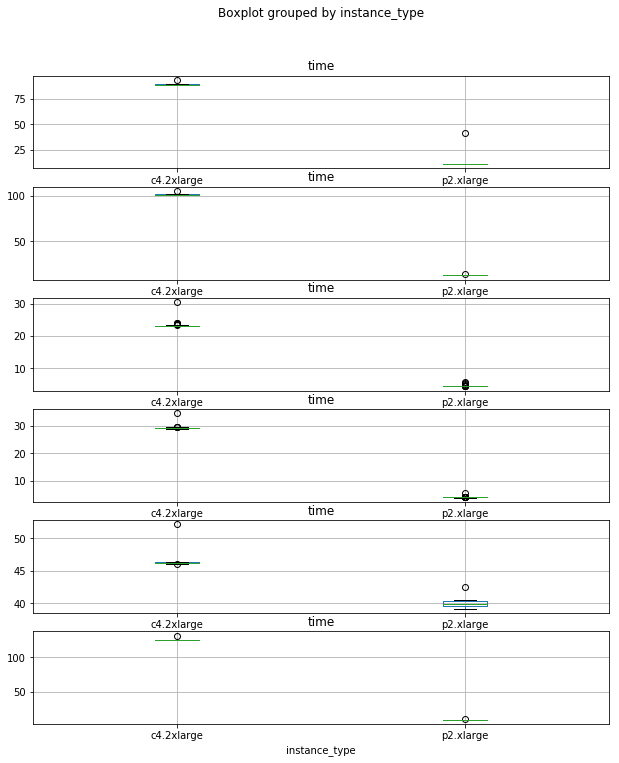

In [75]:
plt.show()